### Author: Michael Polinsky

# Project 4 - Customer Satisfaction Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sbn
import matplotlib
import matplotlib.pyplot as plt
import scipy as sp

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, plot_roc_curve, roc_curve
from sklearn.tree import DecisionTreeClassifier, export_text, export_graphviz
from sklearn.svm import SVC


from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler, OneHotEncoder

import graphviz

from sklearn.feature_selection import SelectKBest, chi2

In [2]:
test = pd.read_csv('test.csv')

In [3]:
train = pd.read_csv('train.csv')

In [4]:
train.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


### Look at a count of each feature and see that the features have varying counts up to 8068.  I can use an imputer to deal with missing values.

In [7]:
pd.DataFrame(train.count())

,0
ID,8068
Gender,8068
Ever_Married,7928
Age,8068
Graduated,7990
Profession,7944
Work_Experience,7239
Spending_Score,8068
Family_Size,7733
Var_1,7992


###  Work Experience appears to be a sparse feature.

<AxesSubplot:>

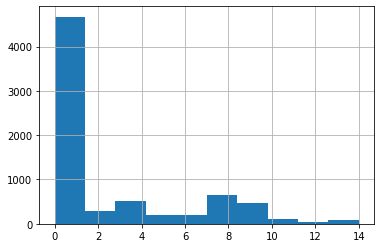

In [9]:
train['Work_Experience'].hist()

### 4 numerics, 7 categorical features.  ID not used to predict.  Segmentation is target.

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


In [50]:
train.nunique()

ID                     8068
Gender                    2
Ever_Married              2
Age                      67
Graduated                 2
Profession                9
Work_Experience          15
Spending_Score            3
Family_Size               9
Var_1                     7
Segmentation              4
AgeGroup                  4
Has_Work_Experience       2
Family_size_range         3
dtype: int64

### Show nulls in each feature.

In [51]:
train.isnull().sum()

ID                        0
Gender                    0
Ever_Married            140
Age                       0
Graduated                78
Profession              124
Work_Experience         829
Spending_Score            0
Family_Size             335
Var_1                    76
Segmentation              0
AgeGroup                132
Has_Work_Experience    3396
Family_size_range       335
dtype: int64

### We only see the numeric features, ID will be removed.

array([[<AxesSubplot:title={'center':'ID'}>,
        <AxesSubplot:title={'center':'Age'}>],
       [<AxesSubplot:title={'center':'Work_Experience'}>,
        <AxesSubplot:title={'center':'Family_Size'}>]], dtype=object)

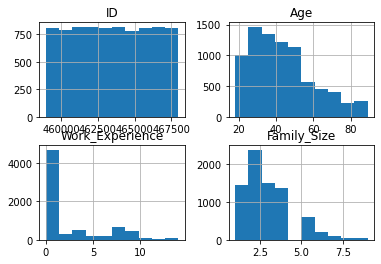

In [52]:
train.hist()

## Check correlations

#### I first tried to create a correlation heatmap like the one below, but discovered that only numeric attributes were included for obvious reasons.  I tried to find a way to get the categorical features in but could not, which is a shame because it's a nice visualization, but I did use cross-tabulation below to explore the impact of different features on 'Segmentation'.

<AxesSubplot:>

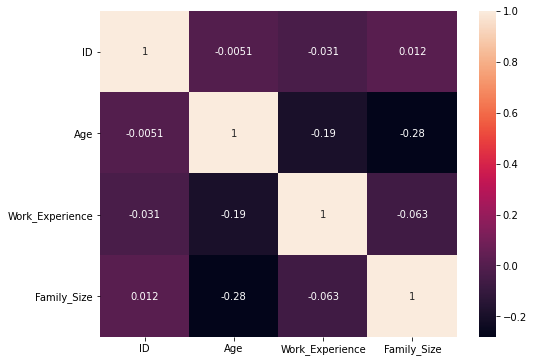

In [47]:
# Heatmap only showing correlations of numeric features with each other.
plt.figure(figsize=(8,6))
sbn.heatmap(crls, cmap='rocket', annot=True)

### Cross Tabulation of Features with target classes

<AxesSubplot:xlabel='Segmentation'>

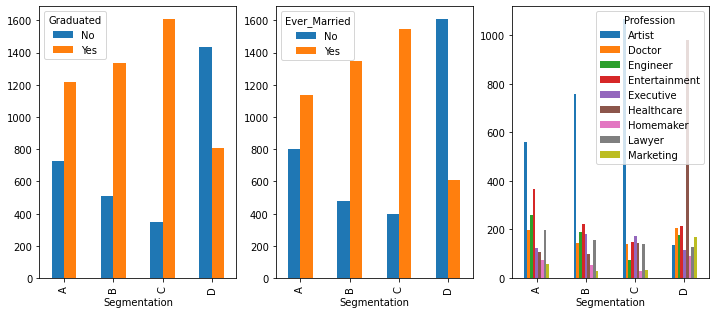

In [94]:
figure, axes = plt.subplots(1, 3)

ct1 = pd.crosstab(train['Segmentation'], train['Graduated'])
ct1.plot.bar(ax = axes[0],figsize=(12,5))

ct2 = pd.crosstab(train['Segmentation'], train['Ever_Married'])
ct2.plot.bar(ax = axes[1], figsize=(12,5))

ct3 = pd.crosstab(train['Segmentation'], train['Profession'])
ct3.plot.bar(ax = axes[2], figsize=(12,5))

#### Education rate seems to decrease from class A to C, then D has a higher rate of No than Yes.  There is a very similar trend for 'Ever_Married'.  Class D also seems to have a majority healthcare workers while A, B, and C appear to have a majority of artists. 

<AxesSubplot:xlabel='Segmentation'>

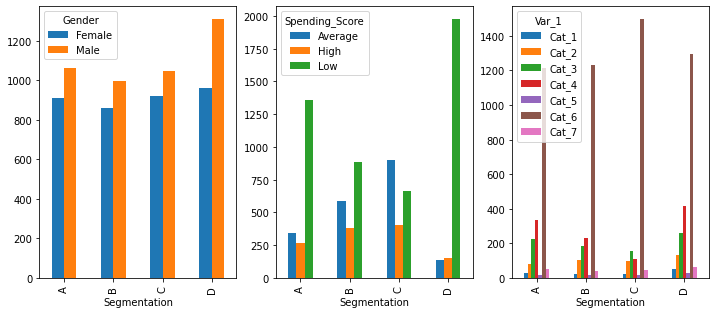

In [93]:
figure, axes = plt.subplots(1, 3)

ct4 = pd.crosstab(train['Segmentation'], train['Gender'])
ct4.plot.bar(ax = axes[0], figsize=(12,5))

ct5 = pd.crosstab(train['Segmentation'], train['Spending_Score'])
ct5.plot.bar(ax = axes[1], figsize=(12,5))

ct6 = pd.crosstab(train['Segmentation'], train['Var_1'])
ct6.plot.bar(ax = axes[2], figsize=(12,5))

### As for Gender and Spending_Score there are less obvious differences in the classes though for Gender class D has a higher number of males and for Spending_Score there is a decrease in Low spending scores in classes B and C relative to A and D, and an inverse change for Average scores.  Var_1 shows no pattern that looks meaningful, and I've dropped it for the training done in this notebook.

## New Features: Rebin Age, Work_Experience, and Family_Size to see if that helps

### Rebin code came from stackoverflow:

https://stackoverflow.com/questions/52753613/grouping-categorising-ages-column-in-python-pandas

#### Age

In [4]:
bins = [18, 30, 44, 64 ,120]
labels = ['18-30', '31-44', '45-64', '65+']
train['AgeGroup'] = pd.cut(train['Age'], bins=bins, labels=labels, right=True)

In [5]:
bins = [18, 30, 44, 64 ,120]
labels = ['18-30', '31-44', '45-64', '65+']
test['AgeGroup'] = pd.cut(test['Age'], bins=bins, labels=labels, right=True)

#### Work_Experience

In [6]:
bins = [0,0.9,1.1]
labels = ['None','Some']
train['Has_Work_Experience'] = pd.cut(train['Work_Experience'], bins=bins, labels=labels, right=False)

In [7]:
bins = [0,0.9,1.1]
labels = ['None','Some']
test['Has_Work_Experience'] = pd.cut(test['Work_Experience'], bins=bins, labels=labels, right=False)

#### Family_Size

In [8]:
bins = [0, 3, 6.9, 20]
labels = ['0-3','4-6', '7-9']
train['Family_size_range'] = pd.cut(train['Family_Size'], bins=bins, labels=labels, right=False)

In [9]:
bins = [0, 3, 6.9, 20]
labels = ['0-3','4-6', '7-9']
test['Family_size_range'] = pd.cut(test['Family_Size'], bins=bins, labels=labels, right=False)

### Cross tabulation for new features

<AxesSubplot:xlabel='Segmentation'>

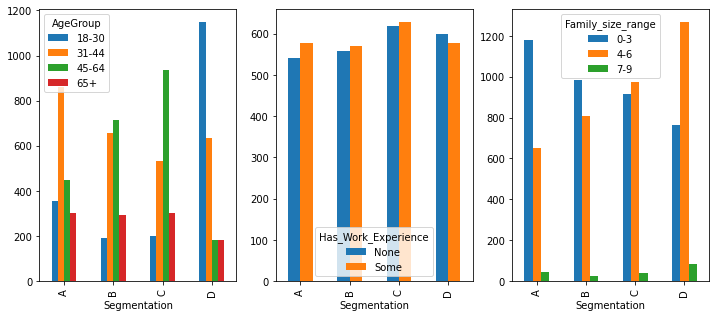

In [106]:
figure, axes = plt.subplots(1, 3)

ct1 = pd.crosstab(train['Segmentation'], train['AgeGroup'])
ct1.plot.bar(ax = axes[0],figsize=(12,5))

ct2 = pd.crosstab(train['Segmentation'], train['Has_Work_Experience'])
ct2.plot.bar(ax = axes[1], figsize=(12,5))

ct3 = pd.crosstab(train['Segmentation'], train['Family_size_range'])
ct3.plot.bar(ax = axes[2], figsize=(12,5))



### It looks like the first and last new features show some variation with the target.  After a few trials the performance seemed to be marginally worse with Has_Work_Experience excluded so I did include it in this notebook.

In [2]:
test = pd.read_csv('test.csv')

In [3]:
train = pd.read_csv('train.csv')

## Creating train and test sets from the given 'train' and 'test' datasets.

In [10]:
X = train.drop(columns=['Segmentation', 'ID', 'Var_1'])
Y = train.loc[:,'Segmentation']

In [11]:
Xtst = test.drop(columns=['Segmentation', 'ID', 'Var_1'])
Ytst = test.loc[:,'Segmentation']

In [12]:
X.shape

(8068, 11)

In [13]:
Xtst.shape

(2627, 11)

## Missing values need to be imputed, Categoricals need to be encoded, Numerics need to be scaled

In [14]:
X.dtypes

Gender                   object
Ever_Married             object
Age                       int64
Graduated                object
Profession               object
Work_Experience         float64
Spending_Score           object
Family_Size             float64
AgeGroup               category
Has_Work_Experience    category
Family_size_range      category
dtype: object

## Pipeline 
### The categorical pipeline uses the Simple Imputer and the ordinal encoder.
### The numeric pipeline uses the KNNImputer and the MinMaxScaler, which seemed to do a little better than the StandardScaler.
### I included a SelectKBest feature selection stage that I tested on all the models, eventually only using with the trees.
### I also added a preprocessor just for the decision tree with entropy, which was the only model that seemed improved by the OneHotEncoder.  

In [15]:

########## First create a pipeline for the categoric attributes

cat_cols = ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score','AgeGroup', 'Has_Work_Experience', 'Family_size_range',]

cat_transformer = Pipeline(steps=[
    # strategies are mean, median, most_frequent, etc.
    ('imputer', SimpleImputer(strategy='most_frequent')),

    # In ordinal encoding, each unique category value is assigned an integer value.
    ('ordinal', OrdinalEncoder())# consider one-hot?
    
   
])

cat_entropy_tree_transformer = Pipeline(steps=[
    # strategies are mean, median, most_frequent, etc.
    ('imputer', SimpleImputer(strategy='most_frequent')),

    # In ordinal encoding, each unique category value is assigned an integer value.
    ('ordinal', OneHotEncoder())# one-hot only helps the entropy D-Tree but it does help it.
    
   
])




########## Second create a pipeline for the numeric attributes

num_cols = ['Age', 'Work_Experience',  'Family_Size']

num_transformer = Pipeline(steps=[
    # Number of neighboring samples to use for K-nearest neighor imputation
    ('imputer', KNNImputer(n_neighbors=4)),

    # StandardScaler makes mean = 0 and scales the data to unit variance 
    ('scaler', MinMaxScaler())
])

#####################


all_cols = ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score','Has_Work_Experience','AgeGroup', 'Family_size_range',]

select_k_transformer = Pipeline(steps=[
   ('select_k_best', SelectKBest(chi2, k=8)),
])

########## Finally, apply column transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ])

entropy_tree_pp = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_entropy_tree_transformer, cat_cols)
    ])

## Then the models are created and fed into their pipelines.

In [16]:
########## A linear kernel classifier
lin_svc_clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', SVC(kernel='linear' ,random_state=42))])

lin_svc_clf_train_score = cross_val_score(lin_svc_clf,  X, Y, cv=3, scoring="accuracy").mean()
lin_svc_clf_test_score = cross_val_score(lin_svc_clf,  Xtst, Ytst, cv=3, scoring="accuracy").mean()

In [17]:
print(lin_svc_clf_train_score)

0.49095037241540757


In [18]:
print(lin_svc_clf_test_score)

0.3479321591650359


In [19]:
########## A poly kernel classifier
poly_svc_clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', SVC(kernel='poly', random_state=42))])

poly_svc_clf_train_score = cross_val_score(poly_svc_clf,  X, Y, cv=3, scoring="accuracy").mean()
poly_svc_clf_test_score = cross_val_score(poly_svc_clf,  Xtst, Ytst, cv=3, scoring="accuracy").mean()

In [20]:
print(poly_svc_clf_train_score)

0.49913010138602215


In [21]:
print(poly_svc_clf_test_score)

0.3414598825831703


In [22]:
########## An RBF kernel classifier
rbf_svc_clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', SVC(kernel='rbf', random_state=42))])

rbf_svc_clf_train_score = cross_val_score(rbf_svc_clf,  X, Y, cv=3, scoring="accuracy").mean()
rbf_svc_clf_test_score = cross_val_score(rbf_svc_clf,  Xtst, Ytst, cv=3, scoring="accuracy").mean()

In [23]:
print(rbf_svc_clf_train_score)

0.51747539081383


In [24]:
print(rbf_svc_clf_test_score)

0.35515938247445095


## Trees

### entropy DT

In [28]:
########## A decicion tree with entropy
entropy_dt_clf = Pipeline(steps=[('preprocessor', entropy_tree_pp),
                                 ('selector', select_k_transformer),
                      ('classifier', DecisionTreeClassifier(criterion='entropy', random_state=42))])

entropy_dt_train_score = cross_val_score(entropy_dt_clf,  X, Y, cv=3, scoring="accuracy").mean()
entropy_dt_test_score = cross_val_score(entropy_dt_clf,  Xtst, Ytst, cv=3, scoring="accuracy").mean()

In [29]:
print(entropy_dt_train_score)

0.49875922974088294


In [30]:
print(entropy_dt_test_score)

0.33422744074798866


### gini DT

In [25]:
########## A decicion tree with gini
gini_dt_clf = Pipeline(steps=[('preprocessor', preprocessor),
                              ('selector', select_k_transformer),
                      ('classifier', DecisionTreeClassifier(criterion='gini', max_depth= 8, max_features=4, random_state=42))])

gini_dt_train_score = cross_val_score(gini_dt_clf,  X, Y, cv=3, scoring="accuracy").mean()
gini_dt_test_score = cross_val_score(gini_dt_clf,  Xtst, Ytst, cv=3, scoring="accuracy").mean()

In [26]:
print(gini_dt_train_score)

0.5049574589762412


In [27]:
print(gini_dt_test_score)

0.3387966949336812


## Graph model scores

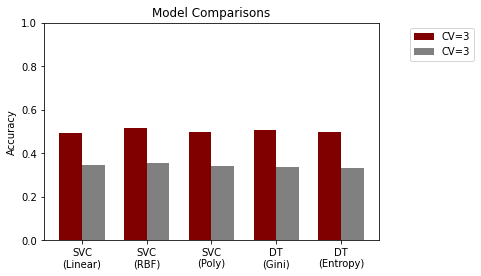

In [31]:
# Summarize the findings for all models

labels = ['SVC\n(Linear)','SVC\n(RBF)','SVC\n(Poly)', 'DT\n(Gini)',  'DT\n(Entropy)']
training_scores = [lin_svc_clf_train_score, rbf_svc_clf_train_score, poly_svc_clf_train_score,gini_dt_train_score,  entropy_dt_train_score]
test_scores = [lin_svc_clf_test_score,rbf_svc_clf_test_score,poly_svc_clf_test_score, gini_dt_test_score, entropy_dt_test_score]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, training_scores, width, label='CV=3', color='maroon')
rects2 = ax.bar(x + width/2, test_scores, width, label='CV=3', color='gray')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_xticks(x)
ax.set_ylim(0,1)
ax.set_xticklabels(labels)
ax.legend(bbox_to_anchor = (1.3, 1.0), loc='upper right')

plt.title('Model Comparisons')
plt.show()

## Learning doesn't seem to be happening.

# DT Knowledge

|--- Gender <= 0.23
|   |--- Gender <= 0.08
|   |   |--- Work_Experience <= 4.50
|   |   |   |--- truncated branch of depth 13
|   |   |--- Work_Experience >  4.50
|   |   |   |--- truncated branch of depth 13
|   |--- Gender >  0.08
|   |   |--- Work_Experience <= 4.50
|   |   |   |--- truncated branch of depth 21
|   |   |--- Work_Experience >  4.50
|   |   |   |--- truncated branch of depth 22
|--- Gender >  0.23
|   |--- Var1 <= 1.50
|   |   |--- Profession <= 0.50
|   |   |   |--- truncated branch of depth 22
|   |   |--- Profession >  0.50
|   |   |   |--- truncated branch of depth 24
|   |--- Var1 >  1.50
|   |   |--- Work_Experience <= 1.50
|   |   |   |--- truncated branch of depth 21
|   |   |--- Work_Experience >  1.50
|   |   |   |--- truncated branch of depth 21



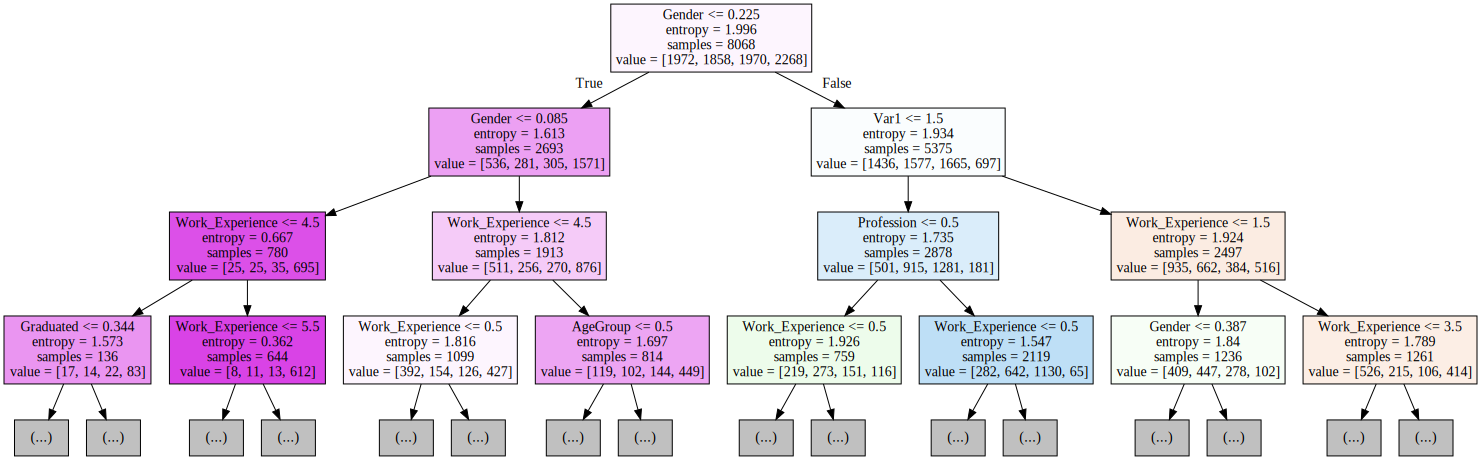

In [32]:
# Convert the decision tree model to text and graph
# we need to refit the DT model that is part of a composite pipe before exporting it as text
entropy_dt_clf['classifier'].fit(preprocessor.fit_transform(X), Y)

text_representation = export_text(entropy_dt_clf['classifier'],
                                  feature_names=['Gender', 'Ever_Married', 'Graduated', 'Age', 'Spending_Score','Profession', 'Work_Experience', 'Var1','Family_Size', 'Family_size_range', 'AgeGroup'],
                                  max_depth=2)
print(text_representation)


# draw the induced decision tree
dot_data = export_graphviz(entropy_dt_clf['classifier'],
                                  max_depth=3,
                                  feature_names=['Gender', 'Ever_Married', 'Graduated', 'Age', 'Spending_Score', 'Profession', 'Work_Experience', 'Var1', 'Family_Size', 'Family_size_range', 'AgeGroup'],
                                  filled=True)

graph = graphviz.Source(dot_data, format="png") 
graph

## The decision tree above only shows one node with entropy < 1.

### Feature importance

Feature: 0, Score: 0.37972
Feature: 1, Score: 0.17070
Feature: 2, Score: 0.10178
Feature: 3, Score: 0.04665
Feature: 4, Score: 0.01895
Feature: 5, Score: 0.04018
Feature: 6, Score: 0.12028
Feature: 7, Score: 0.06275
Feature: 8, Score: 0.01411
Feature: 9, Score: 0.02340
Feature: 10, Score: 0.02148


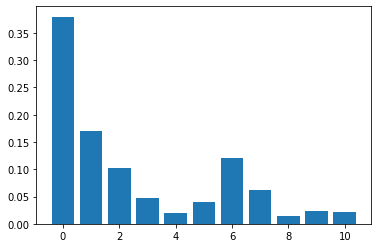

In [33]:
# get feature importances from the model
importance = entropy_dt_clf['classifier'].feature_importances_

# summarize feature importances
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
 
# plot feature importances
plt.bar([x for x in range(len(importance))], importance)
plt.show()

## Hyperparemeter Optimization with GridSearchCV

### DT with gini
#### Using max_depth, max_features, and splitter, which determines how splits are chosen, options are random and (default) best.

In [34]:
# Use GridSearchCV to find optimum hyperparameter values for the DT model


# create a dictionary of all values we want to test
param_grid0 = {'max_depth': np.arange(2,16),
               'max_features': np.arange(1,7),
               'splitter': ['best','random']}      
   
    
# use gridsearch to test all values
grid_search0 = GridSearchCV(gini_dt_clf['classifier'], 
                          param_grid0, 
                           cv=3)
    
# fit the model 
grid_search0.fit(preprocessor.fit_transform(X), Y)


print("The best DT model hyperparameters:", grid_search0.best_params_)
print("The best achieved accuracy after hyperparameter optimization: %.2f \n" % (grid_search0.best_score_))

The best DT model hyperparameters: {'max_depth': 6, 'max_features': 5, 'splitter': 'best'}
The best achieved accuracy after hyperparameter optimization: 0.51 



### DT with entropy
#### Using max_depth, max_features, and splitter.

In [35]:
# Use GridSearchCV to find optimum hyperparameter values for the DT model


# create a dictionary of all values we want to test
param_grid1 = {'max_depth': np.arange(2,16),
               'max_features': np.arange(1,9),
               'splitter': ['best','random']}    
   
    
# use gridsearch to test all values
grid_search1 = GridSearchCV(entropy_dt_clf['classifier'], 
                           param_grid1, 
                           cv=3)
    
# fit the model 
grid_search1.fit(preprocessor.fit_transform(X), Y)

print("The best DT model hyperparameters:", grid_search1.best_params_)   
print("The best achieved accuracy after hyperparameter optimization: %.2f \n" % (grid_search1.best_score_))

The best DT model hyperparameters: {'max_depth': 6, 'max_features': 8, 'splitter': 'best'}
The best achieved accuracy after hyperparameter optimization: 0.52 



### SVC Poly
#### We want higher C and gamma ideally, as the model is underfitting.  Since this is the SVC poly model, it doesn't make sense to test other kernels.  We have two other models for two other kernels.  I tried a number of combinations of values of C and degree, some took up to an hour to complete, discussed more in the summary.

In [66]:
# Use GridSearchCV to find optimum hyperparameter values for the SVC poly model

# create a dictionary of all values we want to test
param_grid2 = {'gamma':['auto','scale'],    
              'degree': [2,3,4],     
              'C': [0.1,1,10]}       
   
    
# use gridsearch to test all values
grid_search2 = GridSearchCV(poly_svc_clf['classifier'], 
                           param_grid2, 
                           cv=3, verbose=10)

# fit the model 
grid_search2.fit(preprocessor.fit_transform(X), Y)


print("The best SVC poly model hyperparameters:", grid_search2.best_params_)   
print("The best achieved accuracy after hyperparameter optimization: %.2f\n" % grid_search2.best_score_)

# C=1000 deg=2 gamma=auto kern=poly time = 2-3 min/fold
# C=1000 deg=3 gamma=auto kern=poly time = 9-15 min/fold

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV 1/3; 1/18] START C=0.1, degree=2, gamma=auto................................
[CV 1/3; 1/18] END ..............C=0.1, degree=2, gamma=auto; total time=   1.3s
[CV 2/3; 1/18] START C=0.1, degree=2, gamma=auto................................
[CV 2/3; 1/18] END ..............C=0.1, degree=2, gamma=auto; total time=   1.3s
[CV 3/3; 1/18] START C=0.1, degree=2, gamma=auto................................
[CV 3/3; 1/18] END ..............C=0.1, degree=2, gamma=auto; total time=   1.2s
[CV 1/3; 2/18] START C=0.1, degree=2, gamma=scale...............................
[CV 1/3; 2/18] END .............C=0.1, degree=2, gamma=scale; total time=   1.2s
[CV 2/3; 2/18] START C=0.1, degree=2, gamma=scale...............................
[CV 2/3; 2/18] END .............C=0.1, degree=2, gamma=scale; total time=   1.2s
[CV 3/3; 2/18] START C=0.1, degree=2, gamma=scale...............................
[CV 3/3; 2/18] END .............C=0.1, degree=2,

#### We can see the improvement is only slight.

## SVC linear
### I wasn't going to try a higher degree because obviously t his is a linear kernal, but again I tried a number of combinations of C and gamma.  I ultimately found I was getting worse results by specifying values for gamma so I went with the two options, 'auto' and 'scale'.

In [43]:
# Use GridSearchCV to find optimum hyperparameter values for the SVC linear model
# was around 25 minutes with degrees 3,4,5 and C 10, 1000

# create a dictionary of all values we want to test
param_grid3 = {'gamma':['auto','scale'], 
               'C': [0.1,1,10]}         
   
    
# use gridsearch to test all values
grid_search3 = GridSearchCV(lin_svc_clf['classifier'], 
                           param_grid3, 
                           cv=3, verbose=10)

# fit the model 
grid_search3.fit(preprocessor.fit_transform(X), Y)

   
print("The best SVC poly model hyperparameters:", grid_search3.best_params_)
print("The best achieved accuracy after hyperparameter optimization: %.2f\n" % grid_search3.best_score_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3; 1/6] START C=0.1, gamma=auto...........................................
[CV 1/3; 1/6] END .........................C=0.1, gamma=auto; total time=   1.2s
[CV 2/3; 1/6] START C=0.1, gamma=auto...........................................
[CV 2/3; 1/6] END .........................C=0.1, gamma=auto; total time=   1.2s
[CV 3/3; 1/6] START C=0.1, gamma=auto...........................................
[CV 3/3; 1/6] END .........................C=0.1, gamma=auto; total time=   1.2s
[CV 1/3; 2/6] START C=0.1, gamma=scale..........................................
[CV 1/3; 2/6] END ........................C=0.1, gamma=scale; total time=   1.2s
[CV 2/3; 2/6] START C=0.1, gamma=scale..........................................
[CV 2/3; 2/6] END ........................C=0.1, gamma=scale; total time=   1.1s
[CV 3/3; 2/6] START C=0.1, gamma=scale..........................................
[CV 3/3; 2/6] END ........................C=0.1, 

## SVC rbf

In [38]:
# Use GridSearchCV to find optimum hyperparameter values for the SVC poly model

# create a dictionary of all values we want to test
param_grid4 = {'gamma':['scale', 'auto'],      
               'degree': [3],     
               'C': [1, 10]}       
    
# use gridsearch to test all values
grid_search4 = GridSearchCV(rbf_svc_clf['classifier'], 
                           param_grid4, 
                           cv=3, verbose=10)

# fit the model 
grid_search4.fit(preprocessor.fit_transform(X), Y)


print("The best SVC poly model hyperparameters:", grid_search4.best_params_)
print("The best achieved accuracy after hyperparameter optimization: %.2f\n" % grid_search4.best_score_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3; 1/4] START C=1, degree=3, gamma=scale..................................
[CV 1/3; 1/4] END ................C=1, degree=3, gamma=scale; total time=   2.3s
[CV 2/3; 1/4] START C=1, degree=3, gamma=scale..................................
[CV 2/3; 1/4] END ................C=1, degree=3, gamma=scale; total time=   2.3s
[CV 3/3; 1/4] START C=1, degree=3, gamma=scale..................................
[CV 3/3; 1/4] END ................C=1, degree=3, gamma=scale; total time=   2.3s
[CV 1/3; 2/4] START C=1, degree=3, gamma=auto...................................
[CV 1/3; 2/4] END .................C=1, degree=3, gamma=auto; total time=   2.3s
[CV 2/3; 2/4] START C=1, degree=3, gamma=auto...................................
[CV 2/3; 2/4] END .................C=1, degree=3, gamma=auto; total time=   2.3s
[CV 3/3; 2/4] START C=1, degree=3, gamma=auto...................................
[CV 3/3; 2/4] END .................C=1, degree=3,

## Display grid search results

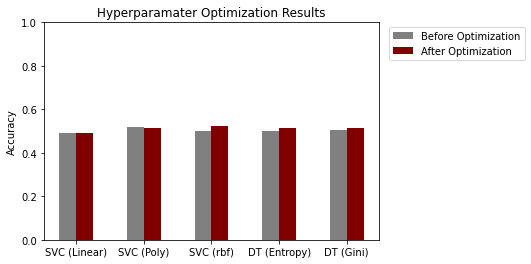

In [67]:
# graph results of grid search for the two models

labels = ['SVC (Linear)', 'SVC (Poly)', 'SVC (rbf)', 'DT (Entropy)', 'DT (Gini)']
before_optimization_scores = [lin_svc_clf_train_score, rbf_svc_clf_train_score, poly_svc_clf_train_score, entropy_dt_train_score, gini_dt_train_score]
after_optimization_scores = [grid_search3.best_score_, grid_search2.best_score_, grid_search4.best_score_, grid_search1.best_score_, grid_search0.best_score_]

x = np.arange(len(labels))  # the label locations
width = 0.25                # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, before_optimization_scores, width, label='Before Optimization', color='gray')
rects2 = ax.bar(x + width/2, after_optimization_scores, width, label='After Optimization', color='maroon')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_xticks(x)
ax.set_ylim(0,1.0)
ax.set_xticklabels(labels)
ax.legend(bbox_to_anchor = (1.45, 1.0), loc='upper right')

plt.title('Hyperparamater Optimization Results')
plt.show()

#### It seems that improving the hyperparameters is not delivering a huge improvement.  It seems that in some cases, hyperparamter tuning is a good way to get a better model from a good model but not a good one from a bad one.

# Summary/Conclusions

### Results

#### In this project my goal was to train five models to classify customers into four classes.  The models used were SVCs with polynomial, linear, and rbf kernels, and decision trees that used entropy and gini for their scores.  

#### As you can see, I can't say my models were able to classify.  There were no pure leaf nodes in my decision trees and the SVCs hovered around 50% accuracy on the training set, and were not able to generalize, with an accuracy between 33-35% on the test set. Initially, the models were achieving closer to 40% accuracy on the training sets, and I made some adjustments that did get them to 50%.  Those adjustments included tweaking the pipeline and attempting to create new features.   

### Pipeline

#### I also used pipelines to prepare the data and found that one-hot encodings for the categorical data slightly improved the score of the decision tree that used entropy, and made a separate preprocessor for that tree. I also found that the MinMaxScaler achieved slightly better results than the StandardScaler, so I used that instead.  The other change I made was to add a feature selection stage with sklearn's SelectKBest class.  It turned out that SelectKBest helped the trees a bit but caused the SVC's accuracy to decline slightly, so I added the transformation only to the trees' pipelines.

### Feature engineering

#### I added three features, 'AgeGroup', 'Has_Work_Experience', and 'Family_size_range', which were just binned versions of 'Age', 'Work_Experience', and 'Family_Size'.  'AgeGroup' and 'Family_size_range'.  When I plotted them there seemed to be clear correlations between the classes the model was predicted and the trends in the engineered features.  Like the other tweaks I made, these features seemed to help only slightly.

#### I also tried limiting the number of features used but that only caused the accuracy to decrease.

### Grid Search

#### To try and discover the best parameters I tried a number of combinations of SVC and DTree parameters.  For the SVC poly I tried a number of combinations of degree from 2 to 6 and C from 0.01 to 1000, which became impractical for certain combinations.  Degree 3 and C=1000 took beteween 8 and 15 minutes for a single fit.  The results I show here were the most promising I had, but in general the best degrees were 2 and 3, and the best C was higher, which makes sense becuase my models are all underfitting.  The grid search did not make the accuracy jump very far, which was expected. 

### Conclusion
#### This was the toughest project so far, and the one I most wanted to keep working on at the deadline. Using the pipeline was intially challenging because in streamlining the process it also obscures things that had been manually coded before.  Now I see how useful the pipeline is, and how it isn't limiting at all, it's really a powerful tool that makes the process cleaner.  I think the feature engineering and data processing stages are where the biggest difference in model quality can be made from where I am now.
#### Something I will remember for the future is to try GridSearch to tune the pipeline parameters, such as the value of k and the metric used in the Select K Best feature selector.

#### If I were to continue with this project I would dig more deeply into how to engineer more relevant features, specifically trying to understnad how to better transfer insights gained from data exploration to feature engineering.